In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
#from evaluation_functions import ensemble_evaluation_functions as eef
#import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
#from calibration_functions import huxt_rank_functions as hrf

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.signal import chirp, find_peaks, peak_widths

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number


# from sklearn.calibration import calibration_curve
# from sklearn.utils import resample
# from sklearn.metrics import mean_squared_error

c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_files_containing_words(directory, keywords):
    """
    creates list of all file name strings containing desired keywords

    Args:
        directory (string) : directory where files are stored
        keywords (list): list of desired keywords
    Returns:
        filtered_files (list) : list of filtered file names with desired keywords
    """

    # Get the list of all files in the directory
    all_files = os.listdir(directory)
    
    # Filter files that contain any of the specified words
    filtered_files = [file for file in all_files if any(word in file for word in keywords)]
    
    return filtered_files


def wsa_date_from_string(file_string):

    """
    extracts date from wsa filename

    Args:
        file_string (string) : wsa model solution file name string
    Returns:
        date_string (string) : date string generated from info within file string format
        date_obj (datetime) : datetime object from file name
    """

    # Define regular expression patterns to extract the date from file string
    pattern = r'21.5rs_(\d{4})(\d{2})(\d{2})(\d{2})' # file string 1
    pattern2 = r'%2F(\d{4})%2F(\d{1,2})%2F(\d{1,2})%2F' # file string 2
    pattern3 = r'gong_(\d{4})(\d{2})(\d{2})(\d{2})' # file string 3
    pattern4 = r'(\d{4})(\d{2})(\d{2})(\d{2})(\d{1})4R000_gongz' #file string 4

    # Match patterns for different WSA file string formats
    match = re.search(pattern, file_string)
    match2 = re.search(pattern2, file_string)
    match3 = re.search(pattern3, file_string)
    match4 = re.search(pattern4, file_string)
    
    # Check each match to find correct format
    if match:
        year, month, day, hour = match.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')
    elif match2:
        year, month, day = match2.groups()
        date_string = f'{year}-{month}-{day}'
        date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    elif match3:
        year, month, day, hour = match3.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')
    elif match4:
        year, month, day, hour, _ = match4.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')
    else:
        print(f"No date found in the string: {file_string}")

    return date_string, date_obj

def downscale_array(original_array, block_size):
    # Get the original dimensions
    original_height, original_width = original_array.shape
    
    # Ensure that the dimensions are divisible by the block size
    if original_height % block_size != 0 or original_width % block_size != 0:
        raise ValueError("The dimensions of the array must be divisible by the block size.")
    
    # Calculate the dimensions of the downscaled array
    new_height = original_height // block_size
    new_width = original_width // block_size
    
    # Reshape the array to create n x n blocks
    reshaped_array = original_array.reshape(new_height, block_size, new_width, block_size)
    
    # Compute the mean along the block dimensions
    downsampled_array = reshaped_array.mean(axis=(1, 3))
    
    return downsampled_array



In [3]:
directory_path = H._setup_dirs_()['boundary_conditions']
wsa_file_words = ['gongz'] # keywords to filter for in coronal model file directory

# create wsa filepaths
wsa_fnames = get_files_containing_words(directory_path, wsa_file_words)
wsafilepaths = [os.path.join(directory_path, fname) for fname in wsa_fnames]

wsa_dates = [wsa_date_from_string(fname)[1] for fname in wsa_fnames]

df_wsa_files = pd.DataFrame({'filepath':wsafilepaths}, index=wsa_dates)

In [4]:
wsa_maps = []

# range of files to read in
start_date = datetime.datetime(2020,6,1)
end_date = datetime.datetime(2021,1,1)
filepath_set = df_wsa_files.loc[start_date:end_date]['filepath'].to_numpy()

for fname in filepath_set:
    WSA_vr_map, WSA_vr_longs, WSA_vr_lats, WSA_br_map, WSA_br_lats, WSA_br_longs, WSA_cr = Hin.get_WSA_maps(fname)
    wsa_maps.append(WSA_vr_map.value)

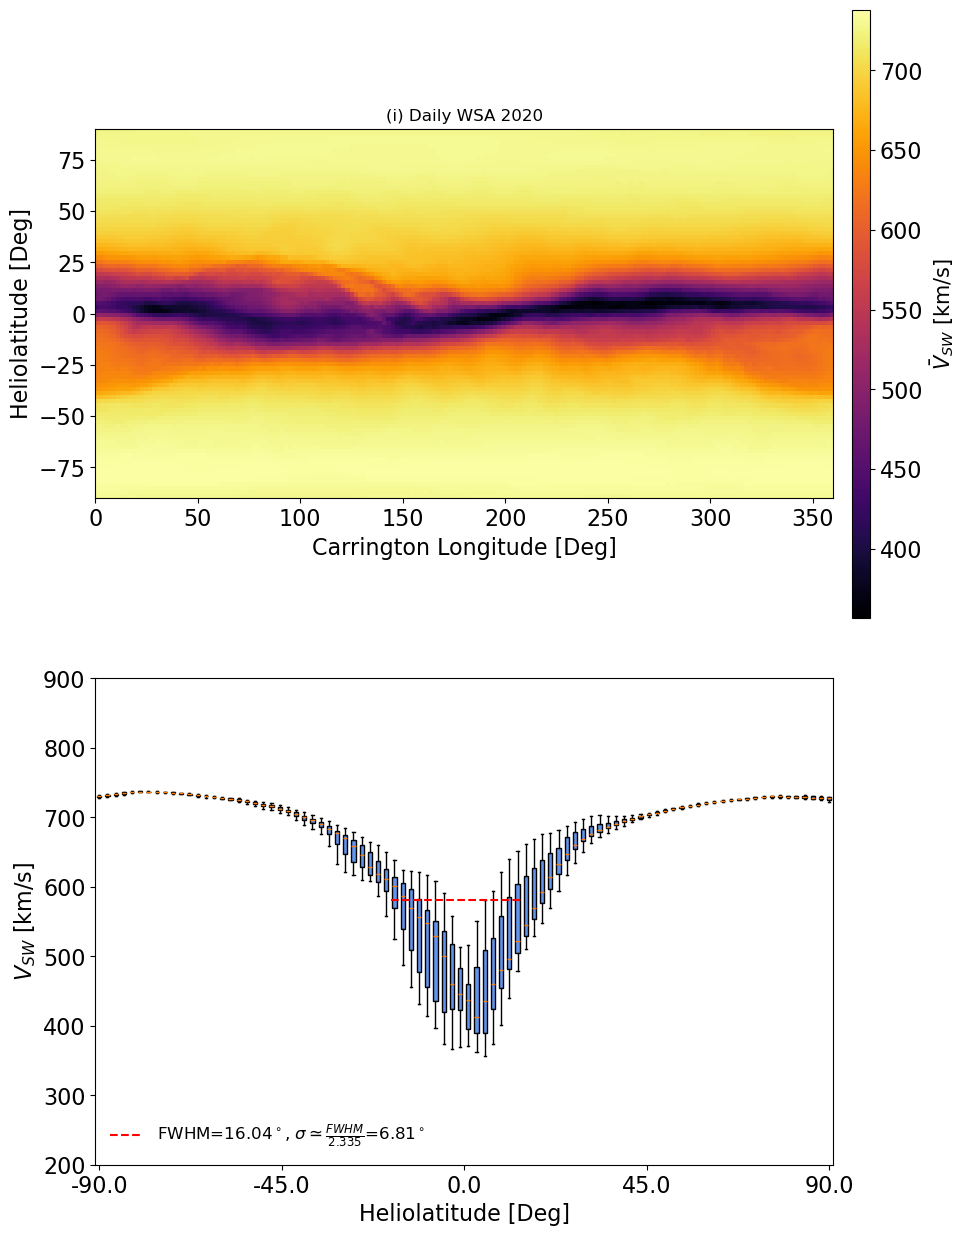

In [5]:
fig = plt.figure(figsize = (10,15), dpi=100)
gs = grd.GridSpec(nrows=3, ncols=3, height_ratios=[5,0.5,4], width_ratios=[20,0.5,0.5], wspace=0.0, hspace=0.0)

ax1 = plt.subplot(gs[0])
im1 = ax1.imshow(np.mean(wsa_maps, axis = 0), origin = 'lower', cmap = 'inferno', extent = (0,360, -90,90))
ax1.set_ylim(-90,90)
ax1.set_ylabel('Heliolatitude [Deg]')
ax1.set_title('(i) Daily WSA 2020')
ax1.set_xlabel('Carrington Longitude [Deg]')

mean_map = np.mean(wsa_maps, axis = 0)
#downsampled_mean_map = downscale_array(mean_map, 1)
downsampled_mean_map = mean_map

ax2 = plt.subplot(gs[6])

bplot = ax2.boxplot(downsampled_mean_map.T, patch_artist=True, showfliers=False)
ax2.set_xticks(np.linspace(1,len(downsampled_mean_map),5))
ax2.set_xticklabels(np.linspace(-90,90,5))

for patch in bplot['boxes']:
    patch.set_facecolor('cornflowerblue')

#Finding peaks + FWHM of zonal mean distribution
peaks_plt, _ = find_peaks(-np.mean(downsampled_mean_map, axis = 1), prominence = 10 )
results_half_plt = peak_widths(-np.mean(downsampled_mean_map, axis = 1), peaks_plt, rel_height=0.5)

peaks, _ = find_peaks(-np.mean(mean_map, axis = 1), prominence = 10 )
results_half = peak_widths(-np.mean(mean_map, axis = 1), peaks, rel_height=0.5)

ax2.hlines(-results_half_plt[1:][0], results_half_plt[1:][1], results_half_plt[1:][2], 
label = f'FWHM={results_half[0][0]:.2f}$^\circ$, $\sigma\simeq\\frac{{FWHM}}{{2.335}}$={results_half[0][0]/2.355:.2f}$^\circ$', 
linestyle = '--', color = 'red')
ax2.legend(frameon = False, loc = 'lower left', fontsize = 12)

# axes[0].text(180, 120, '(a)',fontsize=15)
# ax2.text(30, 715, '(b)',fontsize=15)

ax2.set_ylabel(r'$V_{SW}$ [km/s]')
#axes[0].set_yticklabels(np.linspace(-90,90, 5))

ax2.set_xlabel('Heliolatitude [Deg]')
ax2.set_ylim(200,900)

colorAx = plt.subplot(gs[2])
cb = plt.colorbar(im1, cax = colorAx, aspect = 100)
cb.set_label(r'$\bar{V}_{SW}$ [km/s]', fontsize = 15)

#plt.tight_layout()

# fname = 'ZonalDistributions.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_05\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

In [6]:
def compute_brier_score(forecast, data):
    return np.mean((forecast - data)**2)

def compute_brier_score_components(forecasts, observations, n_bins):
    """
    Computes the Brier score and components (reliability, resolution, and uncertainty).

    Parameters:
    - forecasts: Array of predicted probabilities for the event.
    - observations: Array of binary observations
    - n_bins: Number of bins to group forecasts

    Returns:
    - brier_score
    - reliability
    - resolution
    - uncertainty
    """
    
    # Convert inputs to numpy arrays
    forecasts = np.array(forecasts)
    observations = np.array(observations)

    # compute the single metric brier score
    brier_score = np.mean((forecasts - observations) ** 2)

    # define bins based on forecast probabilities
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(forecasts, bins) - 1
    
    # initialise components
    reliability = 0.0
    resolution = 0.0
    uncertainty = 0.0
    
    # mean event frequency
    event_frequency = np.mean(observations)
    uncertainty = event_frequency * (1 - event_frequency)
    
    # Loop through each bin to calculate reliability and resolution components
    for i in range(n_bins):
        bin_mask = bin_indices == i
        bin_forecasts = forecasts[bin_mask]
        bin_observations = observations[bin_mask]
        
        if len(bin_observations) > 0:
            # Calculate the mean forecast and observation frequency in the bin
            bin_forecast_prob = np.mean(bin_forecasts)
            bin_observed_freq = np.mean(bin_observations)
            
            # Reliability: difference between forecasted and observed probability in each bin
            reliability += len(bin_observations) * ((bin_forecast_prob - bin_observed_freq) ** 2) / len(forecasts)
            
            # Resolution: difference between bin observation frequency and overall event frequency
            resolution += len(bin_observations) * ((bin_observed_freq - event_frequency) ** 2) / len(forecasts)
    
    return {"brier_score": brier_score, "reliability": reliability, "resolution": resolution, "uncertainty": uncertainty}


simple BS evaluation = 0.34498
BS components {'brier_score': 0.34498265620435226, 'reliability': 0.12458995627766278, 'resolution': 0.029491803079273654, 'uncertainty': 0.249964}
reconstructed BS = 0.34506


Text(0, 0.5, 'BS / BS_reconstructed')

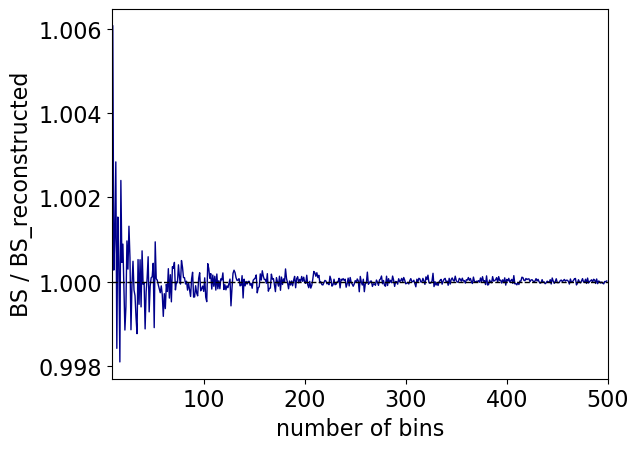

In [7]:
random_seed = 10
rng = np.random.default_rng(random_seed)
N = 1000
probabilistic_forecast = rng.uniform(0,1,size=N)
#print(probabilistic_forecast)
verification_data = np.round(rng.uniform(0,1,size=N))
#print(verification_data)

BS = compute_brier_score(forecast=probabilistic_forecast, data = verification_data)
BS_new = compute_brier_score_components(forecasts=probabilistic_forecast, observations=verification_data, n_bins=100)
print(f'simple BS evaluation = {BS:.5f}')
print(f'BS components {BS_new}')
BS_recon = BS_new['reliability'] - BS_new['resolution'] + BS_new['uncertainty']
print(f'reconstructed BS = {BS_recon:.5f}')

bin_range = np.arange(10,500)

BS = compute_brier_score(forecast=probabilistic_forecast, data = verification_data)
BS_diff = []
for i in bin_range:
        
    BS_new = compute_brier_score_components(forecasts=probabilistic_forecast, observations=verification_data, n_bins=i)
    BS_recon = BS_new['reliability'] - BS_new['resolution'] + BS_new['uncertainty']

    BS_diff.append(BS/BS_recon)

plt.plot(bin_range, BS_diff, lw=1, color='darkblue')
plt.axhline(1, color='black', lw = 1, linestyle = '--')
plt.xlim(9,500)
plt.xlabel('number of bins')
plt.ylabel('BS / BS_reconstructed')


In [8]:
def gen_ensemble_perturbed_boundary_path(E_lat, longitudes, ensemble_size, sigma_latitude, random_seed, uniform=False):
    """
    creates an ensemble of perturbed sub earth paths,
    perturbation is a sinusoidal perturbation in latitude equivalent to rotation of coronal model source.

    Args:
        E_lat (float) : Earth's heliolatitude in radians
        longitudes (array) : longitudinal coords along boundary in radians
        ensemble_size (int) : number of ensemble members 
        sigma_latitude (float) : scale parameter which controls spread of perturbed inner-boundaries in radians
        random_seed (int) : random seed for perturbation generation
    Returns: 
    """

    rng = np.random.default_rng(random_seed) # initialise random number generator

    wave_numbers = np.ones(ensemble_size) # wavenumber set to 1
    phase_offsets = rng.uniform(0, 2*np.pi, size = ensemble_size) # phase set from uniform random distribution

    if uniform == True:
        lat_deviations = rng.uniform(0, sigma_latitude, size = ensemble_size) # max deviation sourced from uniform dist. with range set by sigma_lat
    else:
        lat_deviations = rng.normal(loc = 0, scale = sigma_latitude, size = ensemble_size) # max deviation sourced from gaussian with sigma_lat width
    
    # Generate ensemble of paths
    perturbed_paths = []
    for theta_max, wave_no, phase_off in zip(lat_deviations, wave_numbers, phase_offsets):

        path = E_lat + theta_max * np.sin(wave_no * (longitudes) + phase_off)

        #cut off values above max lat range
        upper_mask = path > np.radians(89)
        lower_mask = path < -np.radians(89)

        # Flat cut-off
        path[upper_mask] = np.radians(89)
        path[lower_mask] = -np.radians(89)

        perturbed_paths.append(path)

    return perturbed_paths * u.rad

def extract_interpolated_velocity_boundary(interpolated_map_solution, boundary, longitudes):
    """
    generates velocity profile across longitudes along perturbed boundary from an interpolated coronal model solution

    Args:
        interpolated_map_solution (object) : interpolation solution object
        boundary (array) : perturbed latitudinal coordinates along inner boundary
        longitudes (array) : longitudinal coords along inner boundary
        
    Returns:
        velocity_boundary (array) : interpolated velocities across longitude (along the inner boundary)
    """

    velocity_boundary = interpolated_map_solution(longitudes, boundary)


def interpolate_vmap(velocity_map, lats, longs):
    """
    Generates an interpolated solution of velocity map ready for sub-earth path extraction

    Args:
        velocity_map (2D array) : coronal model velocity map, shape (n x m)
        lats (array) : latitudinal coords along inner boundary, array of size n
        longs (array) : longitudinal coords along inner boundary, array of size m
    Returns:
        Int_2D_solution (object) : interpolation solution object
    """
    # Generate coordinate grid using n x m defined by length of lats and longs array
    #lat, long = np.mgrid[:len(lats), :len(longs)]

    long, lat = np.meshgrid(longs, lats)

    # This is an array with the shape 2,X --> formatted coordinate grid for interpolation
    X2D = np.array([long.flatten(), lat.flatten()]).T  

    # Run interpolation on velocity map
    Int_2D_solution = scipy.interpolate.LinearNDInterpolator(X2D, velocity_map.flatten())

def earth_latitude_wsa(filename):

    """
    creates list of all file name strings containing desired keywords

    Args:
        filename (string) : wsa model solution file name
    Returns:
        E_lat (float) : average heliolatitude of Earth during timeframe of WSA solution in radians 
    """
        
    # HUXt model parameters
    dt_scale = 4
    r_min = 21.5 * u.solRad
    forecast_window = 27 * u.day

    # getting velocity profile and start time and cr longitude
    _, init_wsa_date = wsa_date_from_string(filename)
    cr, cr_lon_init = Hin.datetime2huxtinputs(pd.Timestamp(init_wsa_date))

    # Use the HUXt ephemeris data to get Earth lat over the CR
    dummymodel = H.HUXt(v_boundary=np.ones(128)*400*(u.km/u.s), simtime=forecast_window, dt_scale=dt_scale, cr_num=cr,
                        cr_lon_init=cr_lon_init, lon_out=0.0*u.deg, r_min = r_min)

    # Retrieve a bodies position at each model timestep:
    earth = dummymodel.get_observer('earth')

    # Get average Earth lat
    E_lat = np.nanmean(earth.lat_c)

    return E_lat

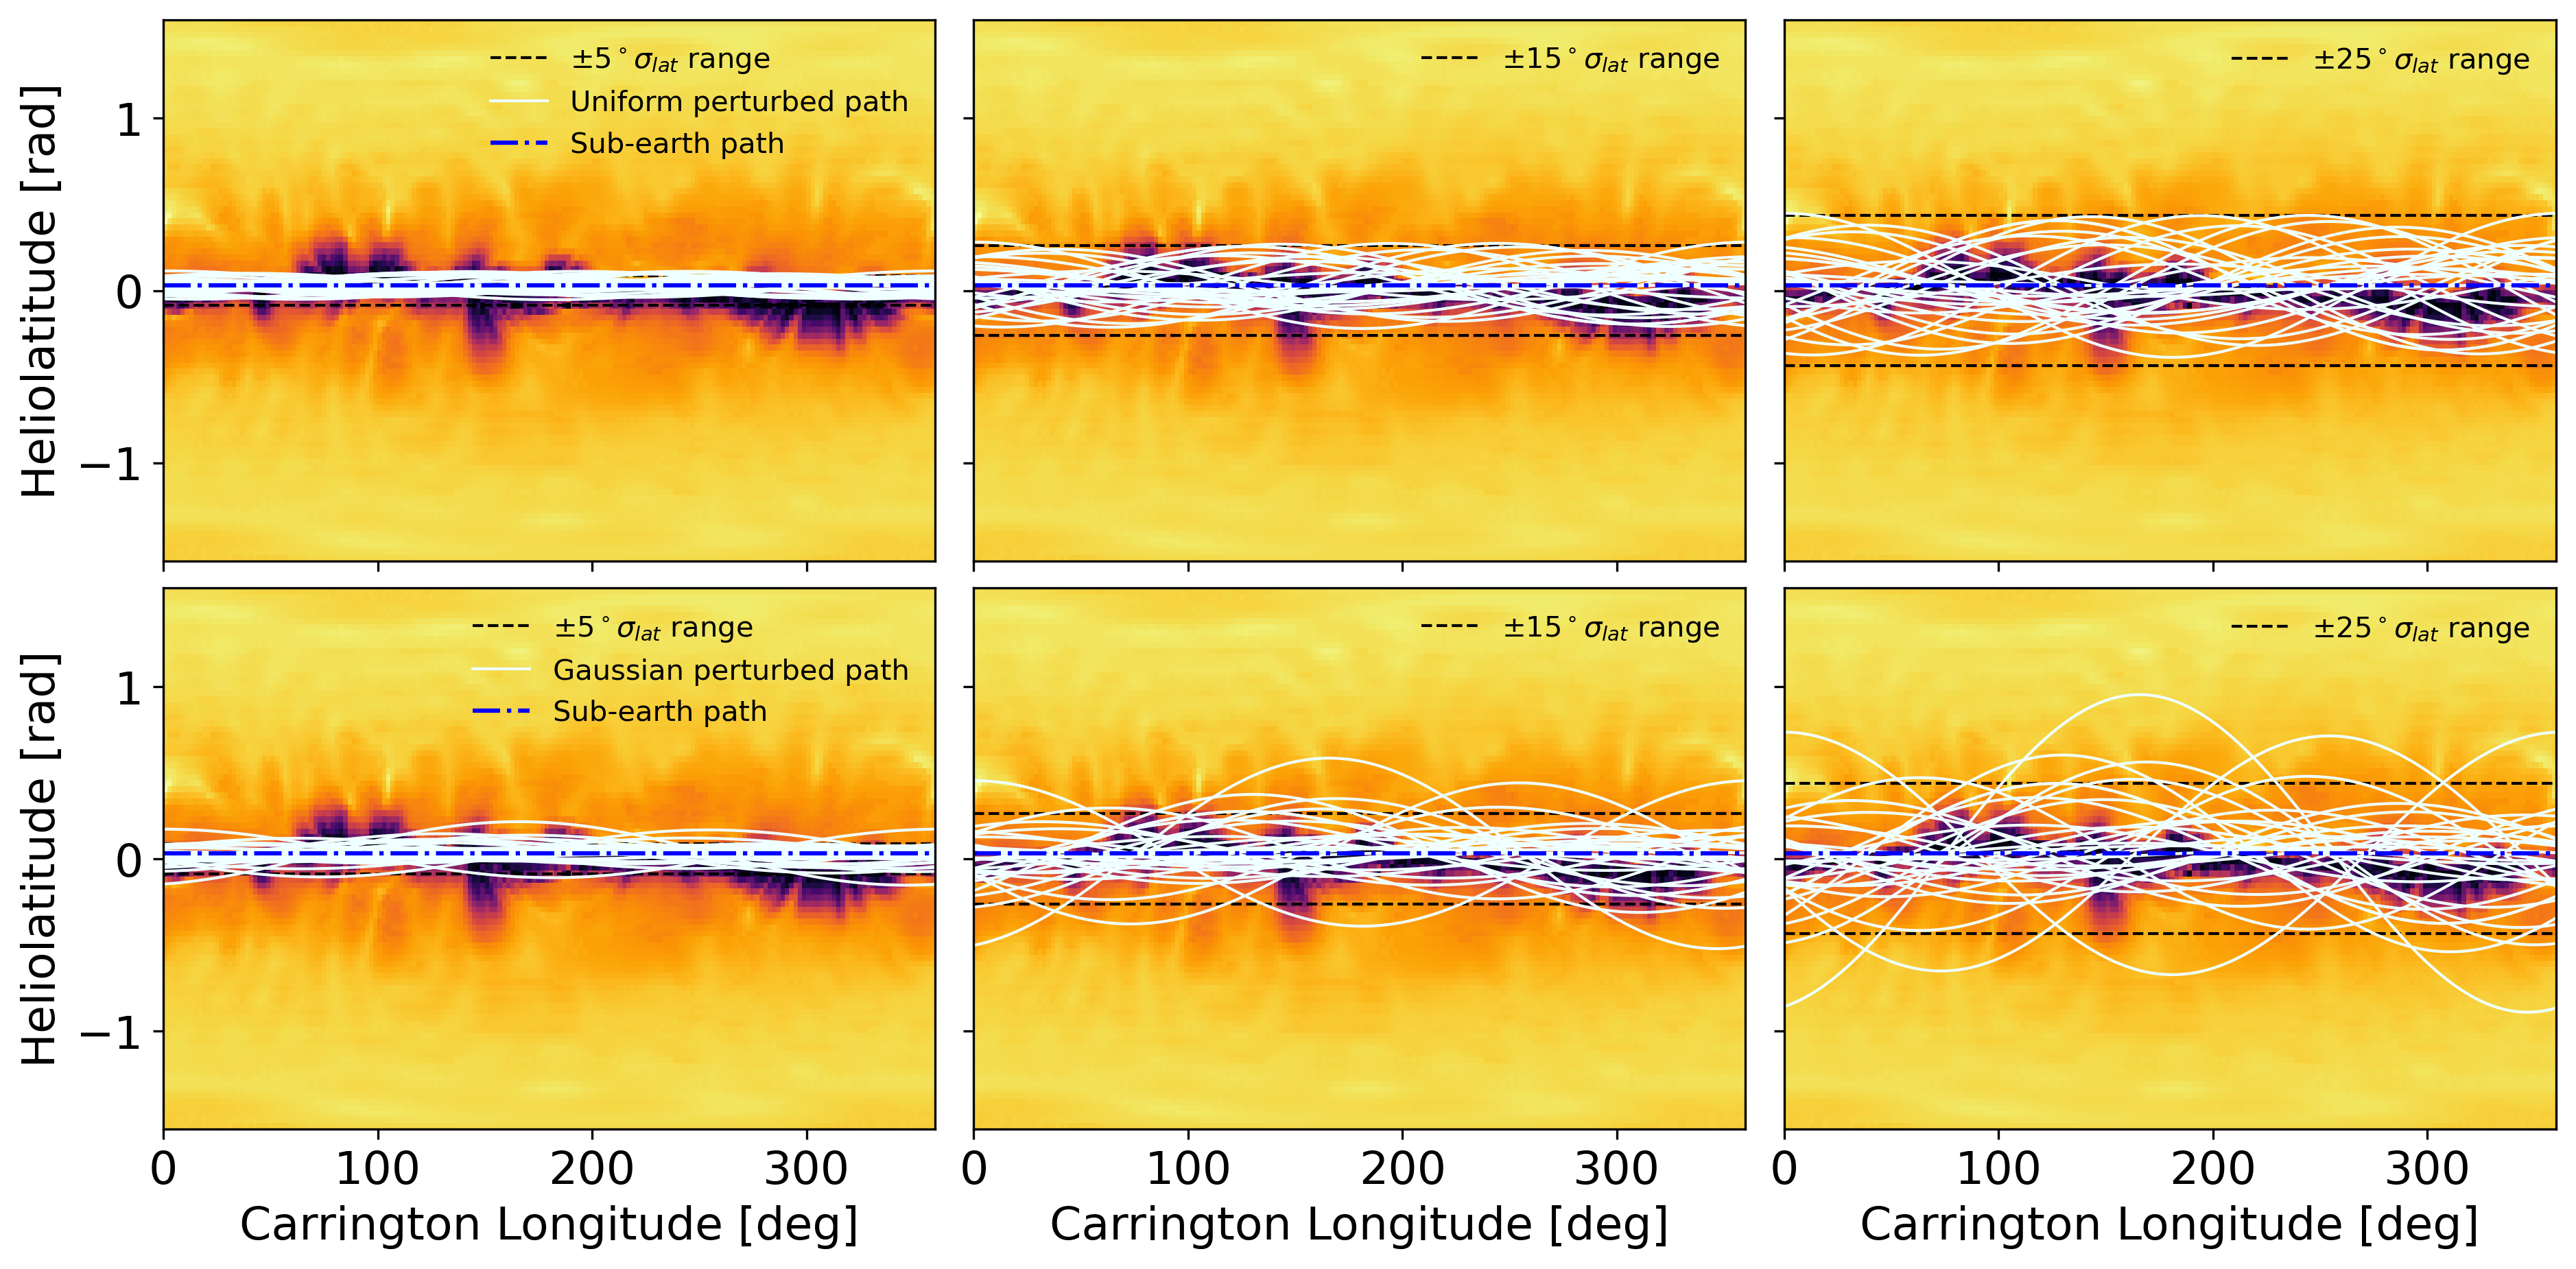

In [9]:
filepath = filepath_set[2]
ensemble_size = 30
random_seed = 20281

# get WSA velocity map and create interpolation solution
WSA_vr_map, WSA_vr_longs, WSA_vr_lats, WSA_br_map, WSA_br_lats, WSA_br_longs, WSA_cr = Hin.get_WSA_maps(filepath)

# deaccelerate the WSA map from 1-AU calibrated speeds to expected 21.5 rS values
vr_map_deacc = WSA_vr_map.copy()
for nlat in range(1, len(WSA_vr_lats)):
    vr_map_deacc[nlat, :], lon_temp = Hin.map_v_inwards(WSA_vr_map[nlat, :], 215 * u.solRad,
                                                        WSA_vr_longs, 21.5 * u.solRad)

INT = interpolate_vmap(vr_map_deacc.value, WSA_vr_lats.value, WSA_vr_longs.value)

E_lat = earth_latitude_wsa(filename = filepath) # sub earth path as basis for 'true' initial conditions

# Generate perturbed inner boundary paths
# # Generate ensemble of interpolated near-sun velocity boundaries
# velocity_boundaries = [extract_interpolated_velocity_boundary(interpolated_map_solution=INT, boundary=boundary.value, longitudes=WSA_vr_longs.value) 
#                     for boundary in perturbed_boundary_paths]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,7), dpi=300, sharey = True, sharex = True)

sigma_latitudes = [5,15,25]

for i, ax in enumerate(axes[0,:]):
    ax.imshow(WSA_vr_map.value, extent = [0,360,-np.pi/2,np.pi/2], aspect='auto', cmap='inferno')

    perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path(E_lat = E_lat.value, longitudes=WSA_vr_longs.value, 
                                                        ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitudes[i]), random_seed = random_seed, uniform=True)
    
    # Width boundaries
    ax.axhline(np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black', label = f'$\pm{sigma_latitudes[i]}^\circ\sigma_{{lat}}$ range')
    ax.axhline(-np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black')

    ax.legend(frameon=False, ncols = 2, fontsize='medium')

    # perturbed boundaries
    for path in perturbed_boundary_paths:
        ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure')  
    ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure', label='Uniform perturbed path')

    #sub-earth path (unperturbed path)
    ax.axhline(E_lat.value, lw=1.5, linestyle = '-.', color = 'blue', label='Sub-earth path')  

for i, ax in enumerate(axes[1,:]):
    ax.imshow(WSA_vr_map.value, extent = [0,360,-np.pi/2,np.pi/2], aspect='auto', cmap='inferno')

    perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path(E_lat = E_lat.value, longitudes=WSA_vr_longs.value, 
                                                        ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitudes[i]), random_seed = random_seed, uniform=False)

    # Width boundaries
    ax.axhline(np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black', label = f'$\pm{sigma_latitudes[i]}^\circ\sigma_{{lat}}$ range')
    ax.axhline(-np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black')
    ax.legend(frameon=False, ncols = 2, fontsize='medium')

    for path in perturbed_boundary_paths:
        ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure')
    ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure', label='Gaussian perturbed path')

    ax.axhline(E_lat.value, lw=1.5, linestyle = '-.', color = 'blue', label='Sub-earth path')     

axes[1,0].legend(frameon = False, ncols = 1, fontsize='medium')
axes[0,0].legend(frameon = False, ncols = 1, fontsize='medium')

axes[0,0].set_ylabel('Heliolatitude [rad]')
axes[1,0].set_ylabel('Heliolatitude [rad]')

axes[1,0].set_xlabel('Carrington Longitude [deg]')
axes[1,1].set_xlabel('Carrington Longitude [deg]')
axes[1,2].set_xlabel('Carrington Longitude [deg]')

fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.show()

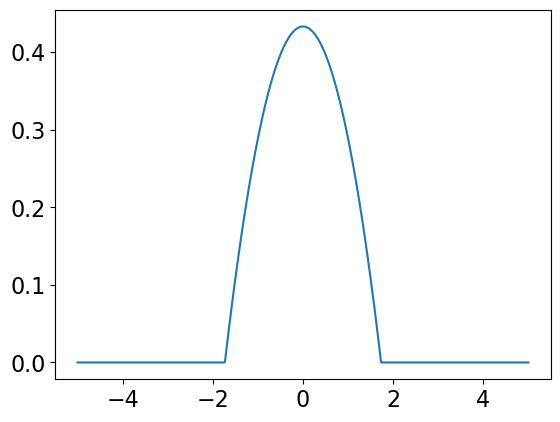

In [11]:
def epc_pdf(x,c):
    return 3*np.max((np.zeros(len(x)),(1-(x/c)**2)),axis=0)/(4*c)

sigma_lat = np.sqrt(3)
x=np.linspace(-5,5,1000)
y = epc_pdf(x, sigma_lat)

plt.plot(x,y)

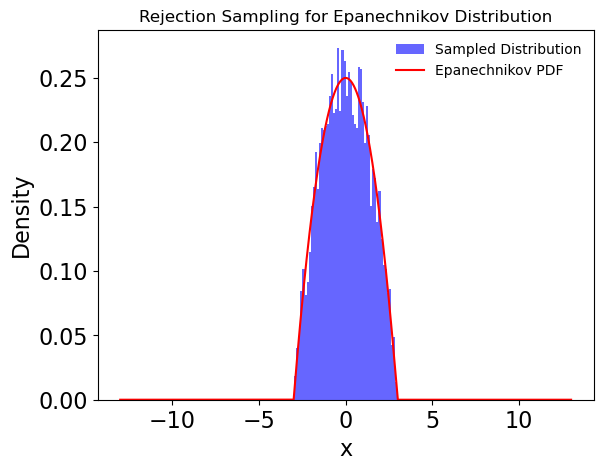

In [ ]:
def epanechnikov_pdf(x, c):
    return 3*np.max((np.zeros(len(x)),(1-(x/c)**2)),axis=0)/(4*c)

def rejection_sampling_epanechnikov(n_samples, c):

    samples = []
    M = 20
    while len(samples) < n_samples:
        x = np.random.uniform(-(c+10), (c+10))  # Sample from uniform
        u = np.random.uniform(0, 1) * M   # Sample from U(0,1) for rejection test
        if u < (1 - (x/c)**2): 
            samples.append(x)
    return np.array(samples)

# Generate samples
n_samples = 5000
c=3e
samples = rejection_sampling_epanechnikov(n_samples, c)

# Plot the histogram
x = np.linspace(-(c+10), c+10, 100000)
pdf_vals = epanechnikov_pdf(x, c)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='b', label='Sampled Distribution')
plt.plot(x, pdf_vals, 'r-', label='Epanechnikov PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend(frameon=False, fontsize='medium')
plt.title('Rejection Sampling for Epanechnikov Distribution')
plt.show()

In [17]:
def gen_ensemble_perturbed_boundary_path_dist(E_lat, longitudes, ensemble_size, sigma_latitude, random_seed, distribution):
    """
    creates an ensemble of perturbed sub earth paths,
    perturbation is a sinusoidal perturbation in latitude equivalent to rotation of coronal model source.

    Args:
        E_lat (float) : Earth's heliolatitude in radians
        longitudes (array) : longitudinal coords along boundary in radians
        ensemble_size (int) : number of ensemble members 
        sigma_latitude (float) : scale parameter which controls spread of perturbed inner-boundaries in radians
        random_seed (int) : random seed for perturbation generation
    Returns: 
    """

    rng = np.random.default_rng(random_seed) # initialise random number generator

    wave_numbers = np.ones(ensemble_size) # wavenumber set to 1
    phase_offsets = rng.uniform(0, 2*np.pi, size = ensemble_size) # phase set from uniform random distribution

    distribution_dict = {'gaussian':rng.normal(loc = 0, scale = sigma_latitude, size = ensemble_size),
                         'uniform':rng.uniform(0, sigma_latitude, size = ensemble_size),
                         'epanechnikov': rejection_sampling_epanechnikov(ensemble_size, sigma_latitude)}
 
    lat_deviations = distribution_dict[distribution]

    # Generate ensemble of paths
    perturbed_paths = []
    for theta_max, wave_no, phase_off in zip(lat_deviations, wave_numbers, phase_offsets):

        path = E_lat + theta_max * np.sin(wave_no * (longitudes) + phase_off)

        #cut off values above max lat range
        upper_mask = path > np.radians(89)
        lower_mask = path < -np.radians(89)

        # Flat cut-off
        path[upper_mask] = np.radians(89)
        path[lower_mask] = -np.radians(89)

        perturbed_paths.append(path)

    return perturbed_paths * u.rad

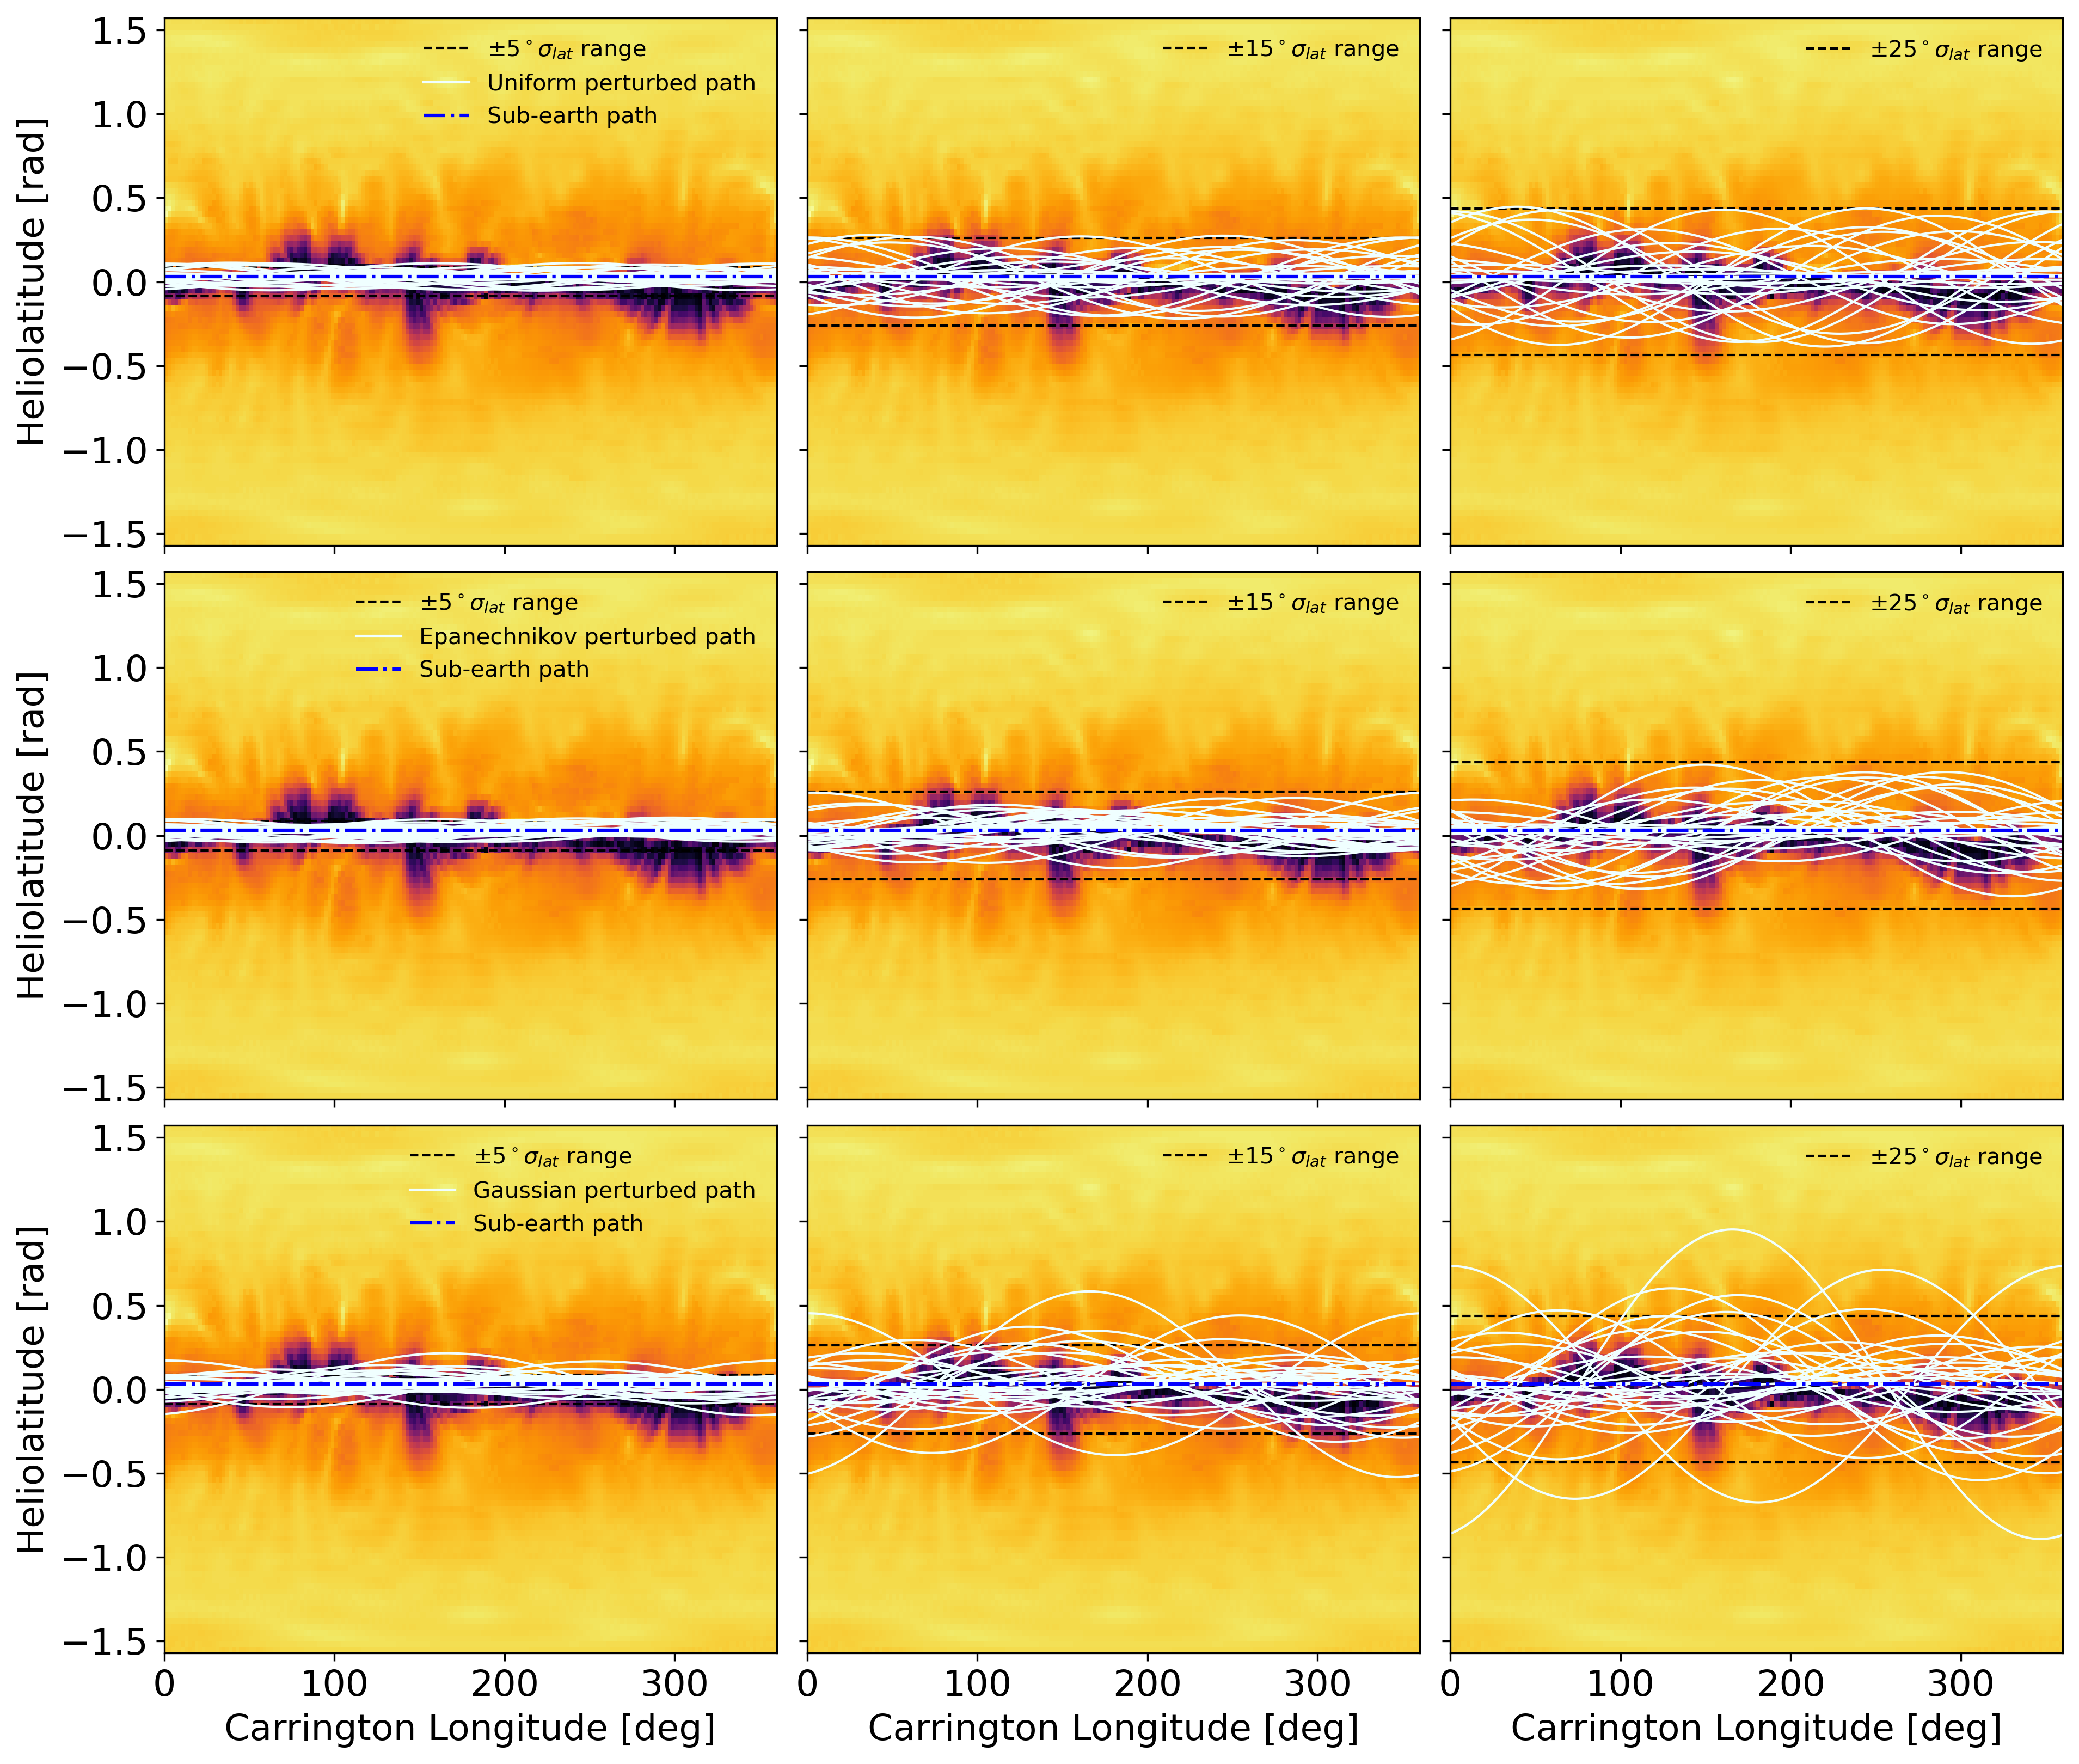

In [21]:
filepath = filepath_set[2]
ensemble_size = 30
random_seed = 20281

# get WSA velocity map and create interpolation solution
WSA_vr_map, WSA_vr_longs, WSA_vr_lats, WSA_br_map, WSA_br_lats, WSA_br_longs, WSA_cr = Hin.get_WSA_maps(filepath)

# deaccelerate the WSA map from 1-AU calibrated speeds to expected 21.5 rS values
vr_map_deacc = WSA_vr_map.copy()
for nlat in range(1, len(WSA_vr_lats)):
    vr_map_deacc[nlat, :], lon_temp = Hin.map_v_inwards(WSA_vr_map[nlat, :], 215 * u.solRad,
                                                        WSA_vr_longs, 21.5 * u.solRad)

INT = interpolate_vmap(vr_map_deacc.value, WSA_vr_lats.value, WSA_vr_longs.value)

E_lat = earth_latitude_wsa(filename = filepath) # sub earth path as basis for 'true' initial conditions

# Generate perturbed inner boundary paths
# # Generate ensemble of interpolated near-sun velocity boundaries
# velocity_boundaries = [extract_interpolated_velocity_boundary(interpolated_map_solution=INT, boundary=boundary.value, longitudes=WSA_vr_longs.value) 
#                     for boundary in perturbed_boundary_paths]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,13), dpi=300, sharey = True, sharex = True)

sigma_latitudes = [5,15,25]

for i, ax in enumerate(axes[0,:]):
    ax.imshow(WSA_vr_map.value, extent = [0,360,-np.pi/2,np.pi/2], aspect='auto', cmap='inferno')

    perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path_dist(E_lat = E_lat.value, longitudes=WSA_vr_longs.value, 
                                                        ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitudes[i]), 
                                                        random_seed = random_seed, distribution='uniform')
    
    # Width boundaries
    ax.axhline(np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black', label = f'$\pm{sigma_latitudes[i]}^\circ\sigma_{{lat}}$ range')
    ax.axhline(-np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black')

    ax.legend(frameon=False, ncols = 2, fontsize='medium')

    # perturbed boundaries
    for path in perturbed_boundary_paths:
        ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure')  
    ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure', label='Uniform perturbed path')

    #sub-earth path (unperturbed path)
    ax.axhline(E_lat.value, lw=1.5, linestyle = '-.', color = 'blue', label='Sub-earth path')  

for i, ax in enumerate(axes[1,:]):
    ax.imshow(WSA_vr_map.value, extent = [0,360,-np.pi/2,np.pi/2], aspect='auto', cmap='inferno')

    perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path_dist(E_lat = E_lat.value, longitudes=WSA_vr_longs.value, 
                                                        ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitudes[i]), 
                                                        random_seed = random_seed, distribution='epanechnikov')
    
    # Width boundaries
    ax.axhline(np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black', label = f'$\pm{sigma_latitudes[i]}^\circ\sigma_{{lat}}$ range')
    ax.axhline(-np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black')

    ax.legend(frameon=False, ncols = 2, fontsize='medium')

    # perturbed boundaries
    for path in perturbed_boundary_paths:
        ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure')  
    ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure', label='Epanechnikov perturbed path')

    #sub-earth path (unperturbed path)
    ax.axhline(E_lat.value, lw=1.5, linestyle = '-.', color = 'blue', label='Sub-earth path')  

for i, ax in enumerate(axes[2,:]):
    ax.imshow(WSA_vr_map.value, extent = [0,360,-np.pi/2,np.pi/2], aspect='auto', cmap='inferno')

    perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path_dist(E_lat = E_lat.value, longitudes=WSA_vr_longs.value, 
                                                        ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitudes[i]), 
                                                        random_seed = random_seed, distribution='gaussian')

    # Width boundaries
    ax.axhline(np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black', label = f'$\pm{sigma_latitudes[i]}^\circ\sigma_{{lat}}$ range')
    ax.axhline(-np.radians(sigma_latitudes[i]), lw=1, linestyle = '--', color = 'black')
    ax.legend(frameon=False, ncols = 2, fontsize='medium')

    for path in perturbed_boundary_paths:
        ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure')
    ax.plot(np.linspace(0,360,180), path, lw = 1, color = 'azure', label='Gaussian perturbed path')

    ax.axhline(E_lat.value, lw=1.5, linestyle = '-.', color = 'blue', label='Sub-earth path')     

axes[2,0].legend(frameon = False, ncols = 1, fontsize='medium')
axes[1,0].legend(frameon = False, ncols = 1, fontsize='medium')
axes[0,0].legend(frameon = False, ncols = 1, fontsize='medium')

axes[0,0].set_ylabel('Heliolatitude [rad]')
axes[1,0].set_ylabel('Heliolatitude [rad]')
axes[2,0].set_ylabel('Heliolatitude [rad]')

axes[2,0].set_xlabel('Carrington Longitude [deg]')
axes[2,1].set_xlabel('Carrington Longitude [deg]')
axes[2,2].set_xlabel('Carrington Longitude [deg]')

fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.show()